In [2]:
import sys
sys.path.insert(0,'charsiu/src/')
from Charsiu import Wav2Vec2ForFrameClassification, CharsiuPreprocessor_en, charsiu_forced_aligner
import torch 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from datasets import load_dataset

TIMIT = load_dataset('timit_asr', data_dir='/home/tomi/Documents/tesis_speechRate/timit')
TIMIT_train = TIMIT['train']
TIMIT_test = TIMIT['test']

sample = TIMIT_train[0]

/home/tomi/.local/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for timit_asr contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/timit_asr
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:

charsiu = charsiu_forced_aligner(aligner='charsiu/en_w2v2_fc_10ms')
modelo = Wav2Vec2ForFrameClassification.from_pretrained("charsiu/en_w2v2_fc_10ms")
modelo.eval()
procesador = CharsiuPreprocessor_en()
x = torch.tensor(np.array([sample['audio']['array']]).astype(np.float32))
with torch.no_grad():
    y = modelo(x).logits

/home/tomi/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/home/tomi/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at charsiu/en_w2v2_fc_10ms were not used when initializing Wav2Vec2ForFrameClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.

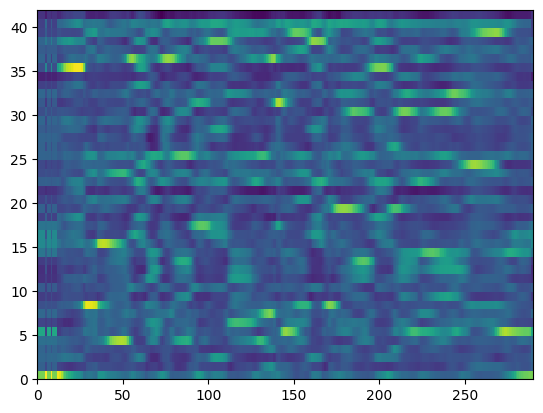

In [11]:
y = y.numpy()[0].T
plt.pcolor(y)

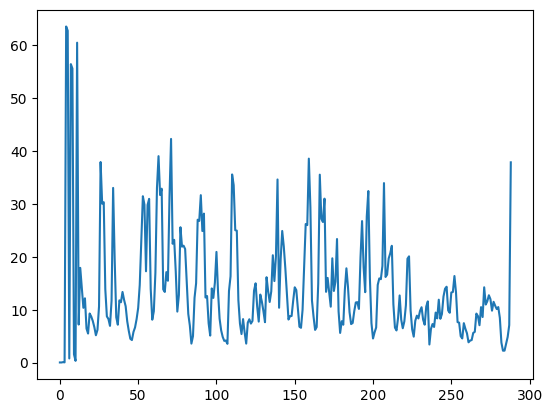

In [18]:
plt.plot(np.abs(np.diff(y)).sum(0))

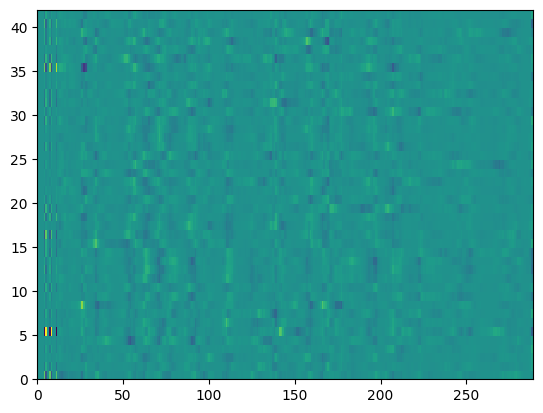

In [20]:
plt.pcolor(np.diff(y))

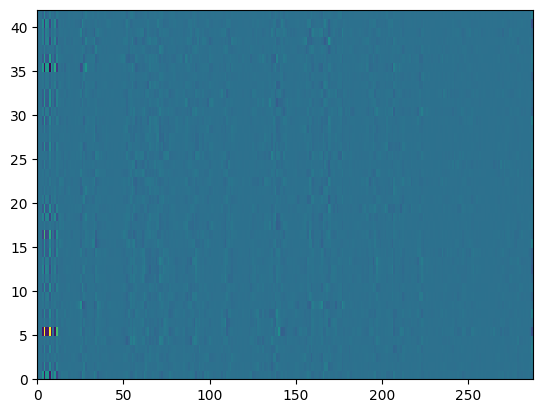

In [21]:
plt.pcolor(np.diff(np.diff(y)))

In [ ]:
# 120 features aprox (charsiu, +delta, +ddelta)

# media, std, abs->media, abs->std

# 480 features

# regresion lineal -> phonerate promedio (con y sin pausas)
